# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно выяснить, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Общая информация

In [1]:
import pandas as pd
import numpy as np

from pymystem3 import Mystem

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
#Q-Q-plot
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [2]:
STATE = 2222

In [3]:
def first_glance(directory, title, **kwargs):
    '''
    Загружает данные; 
    Печатает: 
            Общая информация, 
            5 случайных строк, 
            Количество дубликатов, 
            Количество и процентное соотношение пропусков.
    
    Параметры
    ----------
    directory: str
        Расположение csv файла
    title: str
        Название файла
        
    Возвращает 
    ----------
    DataFrame
    
    '''
    data = pd.read_csv(directory, **kwargs)
    display(title)
    print('-------------Общая информация---------------')
    display(data.info())

    print('------------5 случайных строк---------------') 
    display(data.sample(5, random_state=STATE))
    print()
    
    if data.duplicated().sum().sum() != 0:
        display('-------Количество дубликатов---------', 
        data.duplicated().sum())
    else:
        print('Полные дубликаты отсутствуют')

    if data.isna().sum().sum() != 0:
        # создает датафрейм с количеством пропусков в каждой колонке
        na_values = data.isna().sum().to_frame().rename(columns = {0: 'пропуски'})
        # добавляет новую колонку с процентом пропусков
        na_values['% от общего количества'] = (na_values['пропуски'] / data.shape[0]).round(2)
        # сортирует таблицу по убыванию количества пропусков
        display('--Количество и процентное соотношение пропусков--',
                na_values.sort_values(by = 'пропуски', ascending = False))
    else:
        print('Пропуски отсутствуют')

    print()
    
    print('----------Описательная статистика----------')
    display(data.describe().T)
    
    return data

In [4]:
data = first_glance('/datasets/data.csv', 'Data')

'Data'

-------------Общая информация---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

------------5 случайных строк---------------


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
18069,0,-517.793930,25,высшее,0,женат / замужем,0,M,сотрудник,0,184147.739600,жилье
4636,1,-347.842965,37,среднее,1,женат / замужем,0,F,компаньон,0,115999.432111,получение высшего образования
6605,0,-3617.168602,48,среднее,1,Не женат / не замужем,4,M,сотрудник,1,214785.654014,получение высшего образования
7978,0,-6587.968666,46,среднее,1,женат / замужем,0,M,сотрудник,0,222998.487872,строительство собственной недвижимости
20042,0,348803.565280,51,неоконченное высшее,2,женат / замужем,0,F,пенсионер,0,119218.444568,недвижимость


'-------Количество дубликатов---------'

54

'--Количество и процентное соотношение пропусков--'

,пропуски,% от общего количества
days_employed,2174,0.1
total_income,2174,0.1
children,0,0.0
dob_years,0,0.0
education,0,0.0
education_id,0,0.0
family_status,0,0.0
family_status_id,0,0.0
gender,0,0.0
income_type,0,0.0



----------Описательная статистика----------


,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
dob_years,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


In [5]:
# группировка колонок по двум типам: числовые и категориальные
def group_columns(df):
    numeric_columns = []
    categorical_columns = []

    for column in df.columns:
        if df[column].dtype.name in ['int64', 'float64', 'bool']:
            numeric_columns.append(column)
        if df[column].dtype.name in ['object', 'category', 'datetime64']:
            categorical_columns.append(column)  
            
    return categorical_columns, numeric_columns

In [6]:
cat_columns, num_columns = group_columns(data)

In [7]:
def visualize_info(df, columns):
    '''
    В виде подграфиков:
        Выводит информацию describe;
        Строит графики:
            диаграмма размаха;
            гистограмма;
            график квантиль-квантиль.
    
     Параметры
     ----------
     df: DataFrame
         таблица для графика
     columns: str
         названия колонок с численными данными
    '''
    fig, ax = plt.subplots(len(columns), 4, gridspec_kw={'wspace': 0.5, 'hspace': 0.3})
    fig.set_figheight(5 * len(columns))
    fig.set_figwidth(17)
    
    for i, column in enumerate(columns):
        ax_plot = [ax[i,0], ax[i,1], ax[i,2], ax[i,3]]

        # describe info
        describe_series = round(df[column].describe())
        # создание таблицы на основе перевернутой series.describe() 
        describe_table = ax_plot[0].table(
            cellText=describe_series.values.reshape(describe_series.shape[0],1),
            rowLabels=list(describe_series.index),
            colLabels=[column],
            colWidths = [0.9],
            loc = 'center'
                                         )
        ax_plot[0].grid(False)
        ax_plot[0].axis('off')
        describe_table.scale(1, 2)
        describe_table.auto_set_font_size(False)
        describe_table.set_fontsize(15)
        
        # violin plot
        sns.violinplot(data=df[column], ax=ax_plot[1], color='lightseagreen')
        ax_plot[1].set_xlabel(column, fontsize = 15)
        
        # density plot
        sns.distplot(a=df[column], kde=True, ax=ax_plot[2], color='olive')
        ax_plot[2].set_xlabel(column, fontsize = 15)
        ax_plot[2].set_ylabel('Density', fontsize = 14)
        
        # qq-plot
        sm.qqplot(df[column].astype(np.float64), ax=ax_plot[3], fit=True, line='45')
        ax_plot[3].set_xlabel('Theoretical Quantiles', fontsize = 15)
        ax_plot[3].set_ylabel('Sample Quantiles', fontsize = 15)

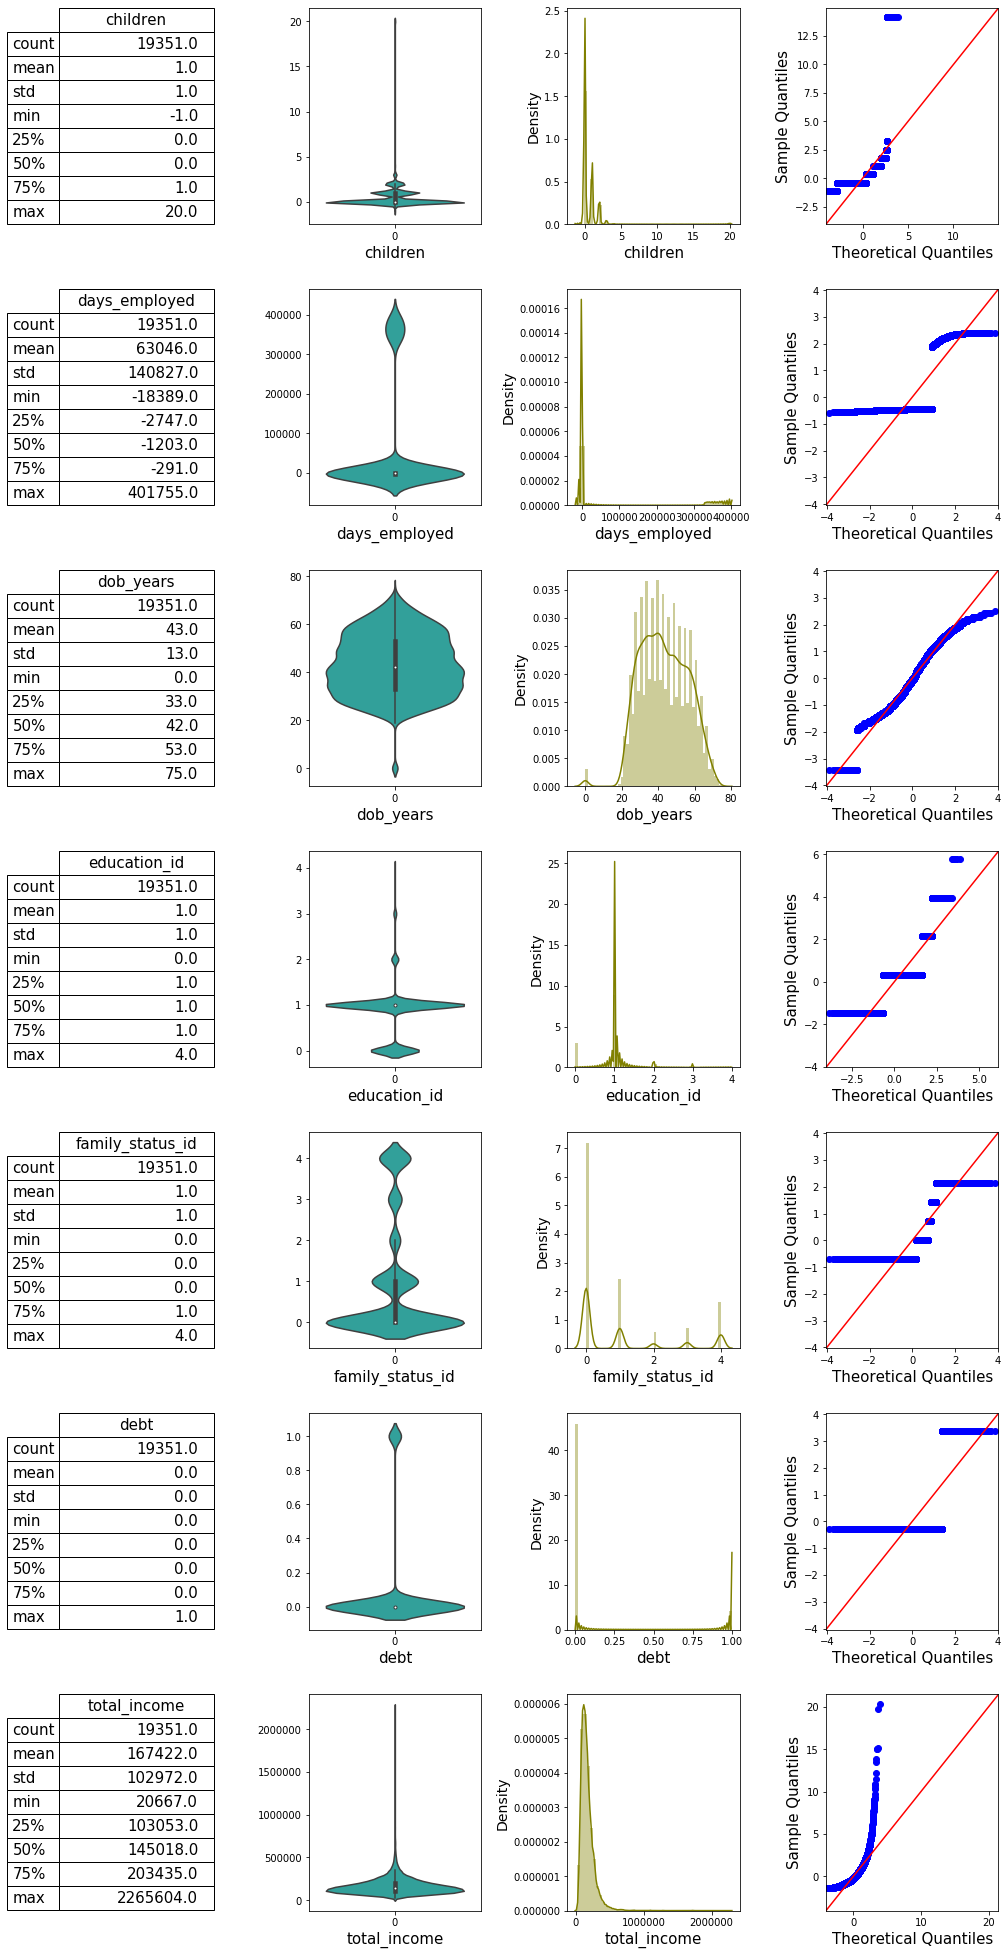

In [8]:
visualize_info(data.dropna(), num_columns)

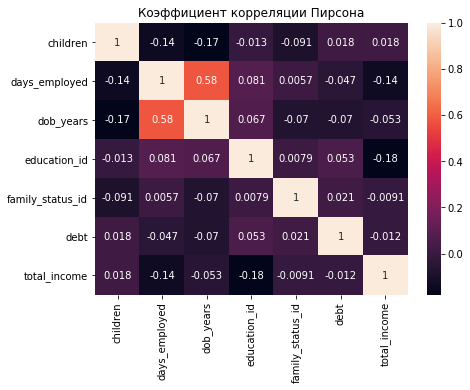

In [9]:
plt.figure(figsize=(7, 5))
ax = plt.axes()
sns.heatmap(data.corr(), annot=True, ax = ax)
ax.set_title("Коэффициент корреляции Пирсона")
plt.show()

**Вывод**

Данные имеют 12 столбцов и 21525 строк, из которых два столбца имеют пропуски или значения других типов, два столбца имеют значения вещественного типа, пять столбцов имеют значения целого типа, остальные - строковые значения. 

Данные содержат пропущенные значения в столбцах со стажем и размером ежемесячного дохода.
В столбцах с информацией о детях имеются подозрительно большие значения при довольно небольшом возрасте и отрицательные значения.

Также имеются полные дубликаты.

Данные о стаже (в днях) имеют аномально высокие значения и отрицательные значения, а также имеют вещественный тип.

Колонка с образованием требует приведения к единому стилю наименований. 
Колонка с целями требует категоризации.
Таблица состоит из 12 столбцов и не очень удобна для просмотра и оценки. 

## Предобработка данных

### Обработка дубликатов

In [10]:
data.duplicated().sum()

54

Из 21525 строк всего 54 являются полными дубликатами, удалим их и обновим индексы для удобства дальнейшей обработки.

In [11]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

Проверим есть ли неявные дубликаты в данных с помощью подсчёта уникальных значений и приведением всех значений к нижнему регистру для категоризации и во избежании ошибок при наименовании их в условиях.

In [12]:
data['education'].value_counts()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

In [13]:
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [14]:
data['family_status'].value_counts()

женат / замужем          12344
гражданский брак          4163
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

In [15]:
data['family_status'] = data['family_status'].str.lower()
data['family_status'].value_counts()

женат / замужем          12344
гражданский брак          4163
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

In [16]:
data['income_type'].value_counts()

сотрудник          11091
компаньон           5080
пенсионер           3837
госслужащий         1457
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

В типах занятости есть пересекающиеся названия, объединим их в одну группу для корректной категоризации в дальнейшем и создадим для них отдельный столбец.

In [17]:
data.loc[data['income_type'] == 'сотрудник', 'income_type_edited'] = 'сотрудник'
data.loc[data['income_type'] == 'госслужащий', 'income_type_edited'] = 'сотрудник'
data.loc[data['income_type'] == 'безработный', 'income_type_edited'] = 'безработный'
data.loc[data['income_type'] == 'студент', 'income_type_edited'] = 'безработный'
data.loc[data['income_type'] == 'в декрете', 'income_type_edited'] = 'безработный'
data.loc[data['income_type'] == 'компаньон', 'income_type_edited'] = 'предприниматель'
data.loc[data['income_type'] == 'пенсионер', 'income_type_edited'] = 'пенсионер'
data.loc[data['income_type'] == 'предприниматель', 'income_type_edited'] = 'предприниматель'

data.groupby('income_type_edited')['income_type_edited'].count()


income_type_edited
безработный            4
пенсионер           3837
предприниматель     5082
сотрудник          12548
Name: income_type_edited, dtype: int64

In [18]:
#проверка корректного создания новых значений во всех строках
data['income_type_edited'].isna().sum()

0

Проверим корректность замены, сравнив общее количество в друх столбцах.

In [19]:
data.duplicated().sum()

17

Появились новые дубликаты, удалим их и сбросим индекс для дальнейшей работы.

In [20]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

**Вывод**

Дубликаты могли появиться в результате некорректной загрузки данных, сбоя в записи данных.

Удаление дубликатов позволит более корректно рассчитать среднее значение и медиану для заполнения пропущенных и нулевых значений.

### Обработка пропусков

**Переведем все отрицательные значения в столбце со стажем и количеством детей в положительные**

Чтобы заполнить пропуски в столбцах со стажем и доходом, избавимся от отрицательных и нулевых значений в стобцах со стажем и возрастом.

In [21]:
for index in data.index:
    if data.loc[index, 'days_employed'] < 0:
        data.loc[index, 'days_employed'] = data.loc[index, 'days_employed'] * -1

Проверим наличие отрицательных значений

In [22]:
data.loc[data['days_employed'] < 0]['days_employed'].count()

0

Избавимся от отрицательных значений в столбце о количестве детей.

In [23]:
def children_positive(row): 
    if row['children'] < 0: 
        row['children'] = row['children'] * -1 
    return row['children']

data['children'] = data.apply(children_positive, axis=1)

Проверим наличие отрицательных значений.

In [24]:
data.loc[data['children'] < 0]['children'].count()

0

In [25]:
data.groupby('children')['children'].count()

children
0     14091
1      4855
2      2052
3       330
4        41
5         9
20       76
Name: children, dtype: int64

Так как максимальное количество детей равно 20 и таких значений много, можно предположить, что это было вызвано ошибкой в сборе данных. Возможно изначально было указано двое детей, а ноль оказался там случайно.

Поэтому необходимо обработать данные значения для получения корректных результатов анализа.

In [26]:
data.loc[data['children'] == 20, 'children'] = 2

In [27]:
data.groupby('children')['children'].count()

children
0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

Проверим, в скольких строках возраст равен нулю.

In [28]:
data.loc[data['dob_years'] == 0]['dob_years'].count()

101

Так как строк с нулевым возрастом немного, заменим их на среднее значение.

In [29]:
mean_age = data['dob_years'].mean()
mean_age

43.271231471986574

In [30]:
data.loc[data['dob_years'] == 0, 'dob_years'] = mean_age

Проверяем, остались ли нулевые значения в колонке с возрастом.

In [31]:
data.loc[data['dob_years'] == 0]['dob_years'].count()

0

Заполняем пропущенные значения о стаже.

In [32]:
# фукнция рассчитывает стаж в зависимости от возраста 
# и заполняет пропущенные значения стажа по каждой строке таблицы с помощью .index

def days_employed_nan(data):
    for index in data.index:
        age = data.loc[index, 'dob_years']
        days_result = (age - 18) * 365

        if pd.isna(data.loc[index, 'days_employed']) == True and age > 18:
            data.loc[index, 'days_employed'] = days_result
        elif pd.isna(data.loc[index, 'days_employed']) == True and age <= 18:
            data.loc[index, 'days_employed'] = 0
    return data

In [33]:
days_employed_nan(data)
data['days_employed'].isna().sum()

0

**Корректировка значений стажа**

В столбце со стажем ниже есть аномально большие значения, если стаж больше максимально возможного для данного возраста, предположим, что данные в этих строках исчисляются в часах, а не днях и разделим такие значения на 24.

In [34]:
data.sort_values(by='days_employed').tail()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_type_edited
7788,0,401663.850046,61.0,среднее,1,гражданский брак,1,F,пенсионер,0,48286.441362,свадьба,пенсионер
2156,0,401674.466633,60.0,среднее,1,женат / замужем,0,M,пенсионер,0,325395.724541,автомобили,пенсионер
7658,1,401675.093434,61.0,среднее,1,женат / замужем,0,F,пенсионер,0,126214.519212,операции с жильем,пенсионер
9991,0,401715.811749,69.0,высшее,0,не женат / не замужем,4,F,пенсионер,0,57390.256908,получение образования,пенсионер
6948,0,401755.400475,56.0,среднее,1,вдовец / вдова,2,F,пенсионер,0,176278.441171,ремонт жилью,пенсионер


In [35]:
# для условия возьмем 366 дней в году, чтобы не делить нормальные значения в днях
# все значения, которые выходят за рамки максимально возможного стажа для данного возраста, 
# предположим, что они даны в часах и разделим их на 24

def days_employed_anomaly(data):
    for index in data.index:
        age = data.loc[index, 'dob_years']
        days_result = (age - 18) * 366

        if data.loc[index, 'days_employed'] > days_result:
            data.loc[index, 'days_employed'] = data.loc[index, 'days_employed'] / 24
    return data

In [36]:
days_employed_anomaly(data)
data.sort_values(by='days_employed', ascending=False)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_type_edited
18614,1,20075.000000,73.0,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,дополнительное образование,пенсионер
10547,0,19710.000000,72.0,среднее,1,не женат / не замужем,4,F,пенсионер,1,NaN,приобретение автомобиля,пенсионер
13838,0,19710.000000,72.0,среднее,1,женат / замужем,0,F,компаньон,0,NaN,сделка с автомобилем,предприниматель
8447,0,19345.000000,71.0,среднее,1,женат / замужем,0,M,пенсионер,0,NaN,операции с коммерческой недвижимостью,пенсионер
11529,0,19345.000000,71.0,среднее,1,женат / замужем,0,M,пенсионер,0,NaN,покупка жилой недвижимости,пенсионер
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12998,0,28.998706,19.0,неоконченное высшее,2,не женат / не замужем,4,F,компаньон,0,165269.027482,автомобили,предприниматель
8327,0,24.240695,32.0,высшее,0,не женат / не замужем,4,M,сотрудник,0,124115.373655,получение дополнительного образования,сотрудник
17394,1,24.141633,31.0,среднее,1,женат / замужем,0,F,сотрудник,1,166952.415427,высшее образование,сотрудник
8307,0,23.170355,19.0,среднее,1,не женат / не замужем,4,F,сотрудник,0,68524.106035,высшее образование,сотрудник


In [37]:
data.sort_values(by='days_employed').tail(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_type_edited
328,0,18615.0,69.0,среднее,1,вдовец / вдова,2,F,сотрудник,0,NaN,приобретение автомобиля,сотрудник
11691,0,18980.0,70.0,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,операции с коммерческой недвижимостью,пенсионер
1303,1,18980.0,70.0,начальное,3,гражданский брак,1,F,сотрудник,0,NaN,операции с коммерческой недвижимостью,сотрудник
13966,0,18980.0,70.0,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,приобретение автомобиля,пенсионер
11529,0,19345.0,71.0,среднее,1,женат / замужем,0,M,пенсионер,0,NaN,покупка жилой недвижимости,пенсионер
6531,0,19345.0,71.0,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,на проведение свадьбы,пенсионер
8447,0,19345.0,71.0,среднее,1,женат / замужем,0,M,пенсионер,0,NaN,операции с коммерческой недвижимостью,пенсионер
13838,0,19710.0,72.0,среднее,1,женат / замужем,0,F,компаньон,0,NaN,сделка с автомобилем,предприниматель
10547,0,19710.0,72.0,среднее,1,не женат / не замужем,4,F,пенсионер,1,NaN,приобретение автомобиля,пенсионер
18614,1,20075.0,73.0,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,дополнительное образование,пенсионер


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 13 columns):
children              21454 non-null int64
days_employed         21454 non-null float64
dob_years             21454 non-null float64
education             21454 non-null object
education_id          21454 non-null int64
family_status         21454 non-null object
family_status_id      21454 non-null int64
gender                21454 non-null object
income_type           21454 non-null object
debt                  21454 non-null int64
total_income          19351 non-null float64
purpose               21454 non-null object
income_type_edited    21454 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 2.1+ MB


**Заполнение пропусков в стобце с доходом**

In [39]:
# сгруппируем данные по типу занятости и посмотрим на размер этих групп
data.groupby('income_type_edited')['income_type_edited'].count()

income_type_edited
безработный            4
пенсионер           3829
предприниматель     5080
сотрудник          12541
Name: income_type_edited, dtype: int64

In [40]:
# выберем строки с отсутсвующими значениями в столбце о доходах
nan_income = data.loc[data['total_income'].isna() == True]

Заполним пропущенные значения дохода медианой для указанной группы по типу занятости. Среднее значение не используем, чтобы не возникло завышенных значений дохода.

In [41]:
#создаем переменные по медиане зарплаты
median_salary_grouped = data.groupby('income_type')['total_income'].transform('median')

#заменяем пропуски медианой по каждой группе
data['total_income'] = data['total_income'].fillna(median_salary_grouped)

In [42]:
data['total_income'].isna().sum()

0

In [43]:
data.groupby('income_type_edited')['total_income'].median()

income_type_edited
безработный         79079.308649
пенсионер          118514.486412
предприниматель    172357.950966
сотрудник          142594.396847
Name: total_income, dtype: float64

**Корректировка пропущенных значения пола**

In [44]:
data.groupby('gender')['gender'].count()

gender
F      14174
M       7279
XNA        1
Name: gender, dtype: int64

Так как в столбце с полом есть пропущенные значение XNA, заменим его на значения пола большинства, т.е 'F'

In [45]:
data.loc[data['gender'] == 'XNA', 'gender'] = 'F'
data.groupby('gender')['gender'].count()

gender
F    14175
M     7279
Name: gender, dtype: int64

**Вывод**

В столбцах со стажем, доходом и полом были пропущенные значения, которые могли возникнуть в результате разного сбора данных, например данные поля были необязательными для заполнения, или совсем отсутствовали.

### Замена типа данных

Стаж в таблице указан в днях, поэтому целесообразнее привести данные значения к целым числам для удобства обработки и наглядности, то же самое необходимо сделать с доходом.

In [46]:
data['days_employed'] = data['days_employed'].astype(int)
data['dob_years'] = data['dob_years'].astype(int)

Данные о долге даны в целых числах, если 1 - была задолженность по кредиту, 0 - не было задолженности, а значит их можно привести к типу boolean(True/False), чтобы нагляднее и логичнее записать условия для категоризации.

In [47]:
data.groupby('debt')['debt'].count()
data['debt'] = data['debt'].astype(bool)

In [48]:
data['total_income'] = data['total_income'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 13 columns):
children              21454 non-null int64
days_employed         21454 non-null int64
dob_years             21454 non-null int64
education             21454 non-null object
education_id          21454 non-null int64
family_status         21454 non-null object
family_status_id      21454 non-null int64
gender                21454 non-null object
income_type           21454 non-null object
debt                  21454 non-null bool
total_income          21454 non-null int64
purpose               21454 non-null object
income_type_edited    21454 non-null object
dtypes: bool(1), int64(6), object(6)
memory usage: 2.0+ MB


**Вывод**

Теперь количественные данные пригодны для дальнейшей работы с ними, в том числе группировки и категоризации.

### Лемматизация

In [49]:
m = Mystem()

Посмотрим на группы, имеющихся целей, чтобы выяснить по каким ключевым словам их категоризировать далее.

In [50]:
data.groupby('purpose')['purpose'].count()

purpose
автомобили                                478
автомобиль                                494
высшее образование                        452
дополнительное образование                460
жилье                                     646
заняться высшим образованием              496
заняться образованием                     408
на покупку автомобиля                     471
на покупку подержанного автомобиля        478
на покупку своего автомобиля              505
на проведение свадьбы                     768
недвижимость                              633
образование                               447
операции с жильем                         652
операции с коммерческой недвижимостью     650
операции с недвижимостью                  675
операции со своей недвижимостью           627
покупка жилой недвижимости                606
покупка жилья                             646
покупка жилья для сдачи                   651
покупка жилья для семьи                   638
покупка коммерческой недви

Так как по списку выше можно проследить лишь четыре основные категории для целей получения кредита, присвоим им соответсвующие названия категорий в новом столбце.

In [51]:
# проводится лемматизация столбца с целями по каждой строке в столбце 'purpose' 
# т.к лемматизация возвращает значения в виде списка, 
# сразу применяем метод join() для преобразования списка в сроку, 
# чтобы воспользоваться условием if in

# функия ищет подходящее название категории 
# в исходном столбце с целями и возвращает новую категорию

def lemmas_purpose(row):
    purpose_lemma = ' '.join(m.lemmatize(row['purpose']))

    if 'автомобиль' in purpose_lemma:
        return 'автомобиль'
    elif 'недвижимость' in purpose_lemma or 'жил' in purpose_lemma:
        return'недвижимость'
    elif 'образование' in purpose_lemma:
        return 'образование'
    else:
        return 'свадьба'

In [52]:
# добавим новые категории в отдельный столбец таблицы
data['purpose_category'] = data.loc[10:20].apply(lemmas_purpose, axis=1)

In [53]:
data['purpose_category'].loc[10:20]

10    недвижимость
11    недвижимость
12         свадьба
13      автомобиль
14    недвижимость
15    недвижимость
16    недвижимость
17    недвижимость
18      автомобиль
19      автомобиль
20    недвижимость
Name: purpose_category, dtype: object

In [54]:
data['purpose_category'] = data.apply(lemmas_purpose, axis=1)
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_type_edited,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,False,253875,покупка жилья,сотрудник,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,False,112080,приобретение автомобиля,сотрудник,автомобиль
2,0,234,33,среднее,1,женат / замужем,0,M,сотрудник,False,145885,покупка жилья,сотрудник,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,False,267628,дополнительное образование,сотрудник,образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,False,158616,сыграть свадьбу,пенсионер,свадьба


In [55]:
data['purpose_category'].isna().sum()

0

In [56]:
data.groupby('purpose_category')['purpose_category'].count()

purpose_category
автомобиль       4306
недвижимость    10811
образование      4013
свадьба          2324
Name: purpose_category, dtype: int64

**Вывод**

Проведённая лемматизация помогла категоризировать данные по целям, что в дальнейшем можно использовать в поиске зависимостей между данной категорией и другими значениями.

### Категоризация данных

**Сгруппируем данные по типам дохода и количеству задолженностей в каждой группе.**

Разделим данные на несколько категорий по уровню доходов, чтобы оценить зависимость возвратов кредита в срок для каждой из групп.

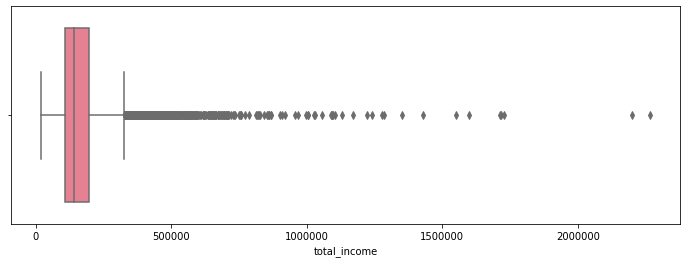

In [57]:
plt.figure(figsize=(12, 4))
sns.boxplot(data['total_income'], palette="husl")
plt.show()

In [58]:
data['total_income_category'] = pd.qcut(data['total_income'], 4, labels=["низкий", "средний", "выше среднего", "высокий"])
print(data['total_income_category'].value_counts())

средний          5479
высокий          5364
низкий           5364
выше среднего    5247
Name: total_income_category, dtype: int64


In [59]:
data['total_income_category'].isna().sum()

0

In [60]:
total_category_grouped = data.groupby('total_income_category')['total_income_category'].count()
total_category_grouped

total_income_category
низкий           5364
средний          5479
выше среднего    5247
высокий          5364
Name: total_income_category, dtype: int64

In [61]:
# сгруппируем данные по доходам и долгам в каждой группе
total_category_grouped_debt = data.groupby('total_income_category')['debt'].sum()
total_category_grouped_debt

total_income_category
низкий           427.0
средний          483.0
выше среднего    448.0
высокий          383.0
Name: debt, dtype: float64

**Сгруппируем данные по количеству детей и количеству задолженностей в каждой группе.**

Для начала, распределим имеющиеся данные на три группы по количеству детей.

In [62]:
def children_groups(row):
    condition = row['children']
    if condition == 0:
        row['children_category'] = 'без детей'
    elif 0 < condition <= 2:
        row['children_category'] = 'малодетные'
    else:
        row['children_category'] = 'многодетные'
    return row['children_category']

data['children_category'] = data.apply(children_groups, axis=1)

In [63]:
data.groupby('children_category')['children_category'].count()

children_category
без детей      14091
малодетные      6983
многодетные      380
Name: children_category, dtype: int64

**Сгруппируем данные по семейному статусу и количеству задолженностей в каждой группе.**

In [64]:
family_status_grouped = data.groupby('family_status')['family_status'].count()
family_status_grouped

family_status
в разводе                 1195
вдовец / вдова             959
гражданский брак          4151
женат / замужем          12339
не женат / не замужем     2810
Name: family_status, dtype: int64

**Сгруппируем данные по  целям получения кредита и количеству задолженностей в каждой группе.**

In [65]:
purpose_category_grouped = data.groupby('purpose_category')['purpose_category'].count()
purpose_category_grouped

purpose_category
автомобиль       4306
недвижимость    10811
образование      4013
свадьба          2324
Name: purpose_category, dtype: int64

In [66]:
purpose_category_grouped_debt = data.groupby('purpose_category')['debt'].sum()
purpose_category_grouped_debt

purpose_category
автомобиль      403.0
недвижимость    782.0
образование     370.0
свадьба         186.0
Name: debt, dtype: float64

**Сгруппируем данные по типу занятости и задолженностям в каждой группе.**

In [67]:
income_type_edited_grouped = data.groupby('income_type_edited')['income_type_edited'].count()
income_type_edited_grouped_debt = data.groupby('income_type_edited')['debt'].sum()
income_type_edited_grouped_debt

income_type_edited
безработный           2.0
пенсионер           216.0
предприниматель     376.0
сотрудник          1147.0
Name: debt, dtype: float64

**Вывод**

Данные проверены, категоризированы и готовы к заключительному сравнительному анализу по группам.

## Корреляции

In [68]:
def pivot(data, index):
    '''
    Строит сводную таблицу:
        count - общее число клиентов;
        sum - кол-во должников;
        mean - процент должников в группе.
    
    Параметры
    ----------
    data: DataFrame
        Данные для построения сводной таблицы
    index: str
        Название колонки для использования в качестве индекса сводной таблицы
        
    Возвращает 
    ----------
    DataFrame
    Barplot
    
    '''
    pivot = data.pivot_table(index = index, values = 'debt', aggfunc = ['count', 'sum', 'mean']).reset_index()
    pivot.columns = [index, 'Кол-во клиентов', 'Кол-во должников', '% невозврата']
    display(pivot.sort_values('% невозврата', ascending = False))
    
    fig = px.bar(pivot, x = index, y = '% невозврата', color = '% невозврата', title = '% невозврата по ' + index)
    fig.show()

**Есть ли зависимость между наличием детей и возвратом кредита в срок?**

Рассчитаем соотношение количества детей и наличие задолженностей для каждой группы.

In [69]:
#pivot(data, 'children_category')
# работа функции отображена в виде изображения ниже 
# из-за особенностей отображения графиков Plotly в Github

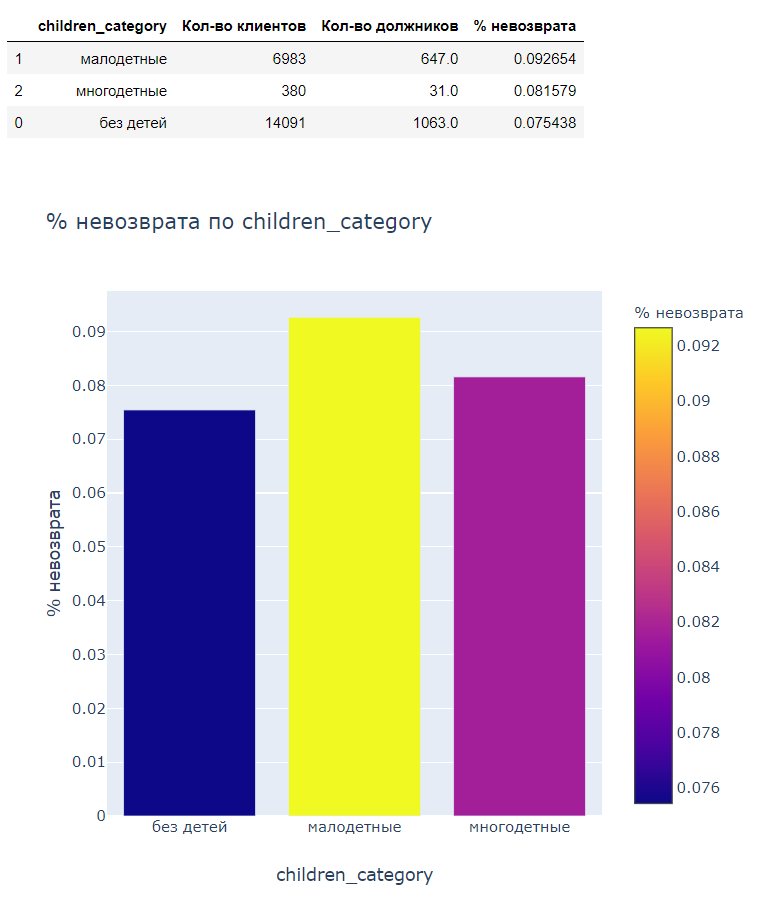

**Вывод**

Существует зависимость между наличием детей и возвратом кредита в срок. По процентному соотношению детей и долгов видна тенденция к увеличению количества задолженностей в малодетных семьях (с одним-двумя детьми), в то же время многодетные семьи имеют меньшее количество задолженностей по сравнению с малодетными.

Наименьшее количество задолженностей имеют люди без детей.

**Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Рассчитаем соотношение наличия задолженностей в каждой группе по семейному положению.

In [70]:
#pivot(data, 'family_status')
# работа функции отображена в виде изображения ниже 
# из-за особенностей отображения графиков Plotly в Github

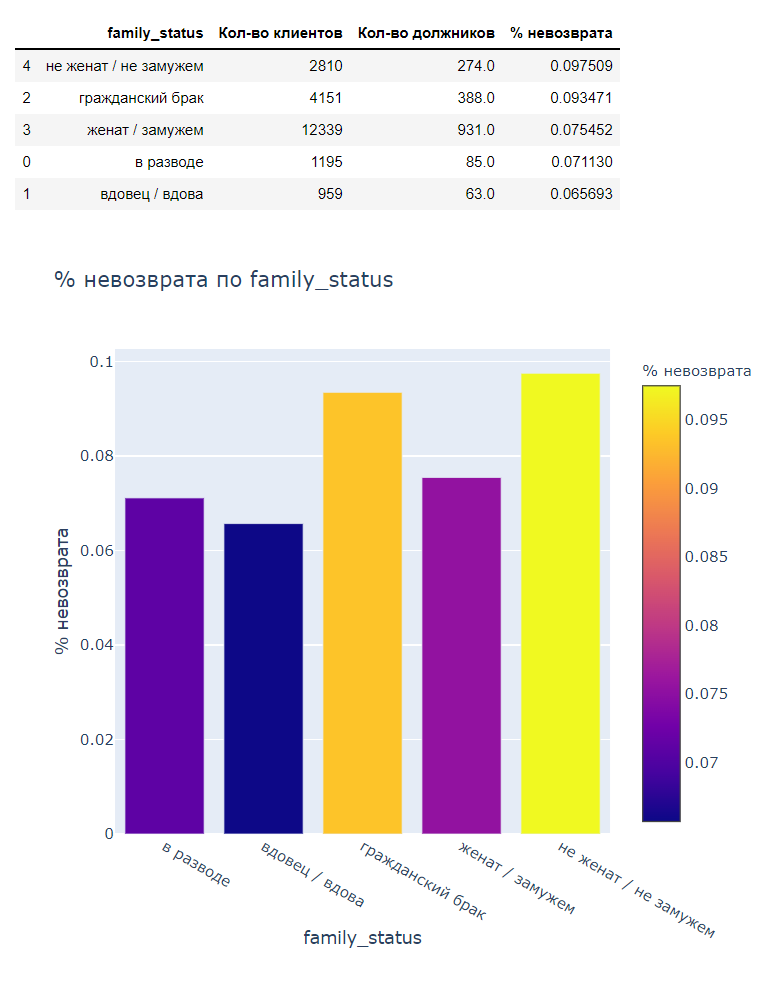

**Вывод**

Существует зависимость между семейным положением и возвратом кредита в срок. Заметна тенденция к задолжностям у людей, которые указывают свой семейный статус как "гражданский брак", а также "не женат/замужем".

Наименьшее количество задолженностей имели люди со статусом "вдова/вдовец". Оставшиеся две категории практически не имеют различий.


**Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Рассчитаем соотношение уровня дохода и наличие задолженностей для каждой группы.

In [71]:
#pivot(data, 'total_income_category')
# работа функции отображена в виде изображения ниже 
# из-за особенностей отображения графиков Plotly в Github

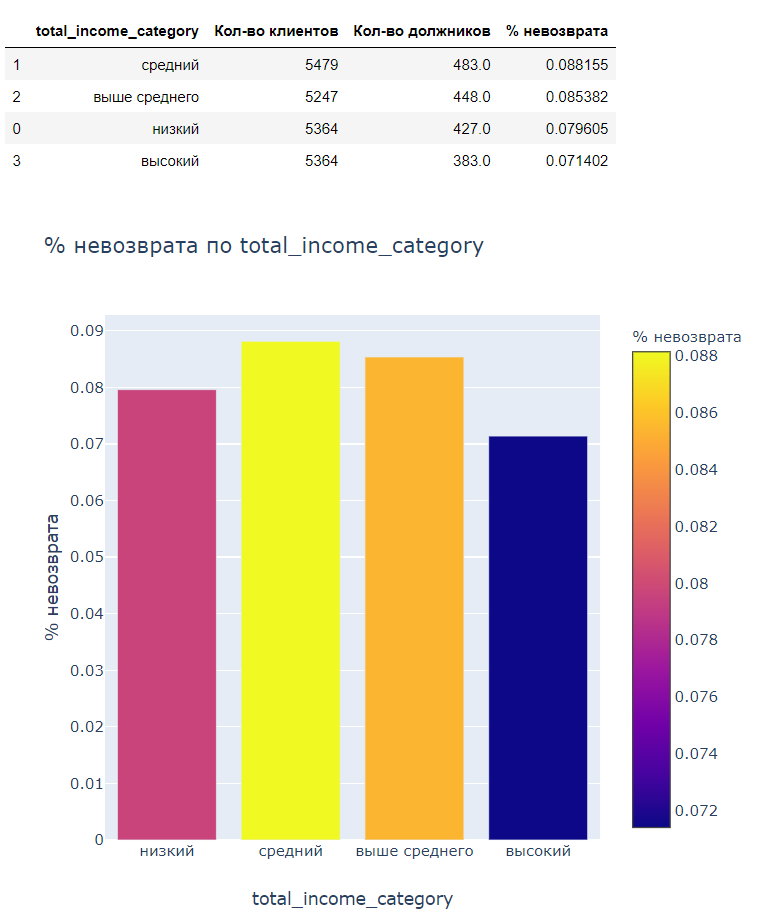

**Вывод**

Есть некоторая зависимость между уровнем дохода и возвратом кредита в срок. По процентному соотношению доходов и долгов можно увидеть, что максимальное количество задолженностей имеют категории людей со средним и выше среднего доходом, а минимальное - с высоким доходом. 

**Есть ли зависимость между типом занятости и возвратом кредита в срок?**

Соотношение наличия задолжностей и типа занятости.

In [72]:
#pivot(data, 'income_type_edited')
# работа функции отображена в виде изображения ниже 
# из-за особенностей отображения графиков Plotly в Github

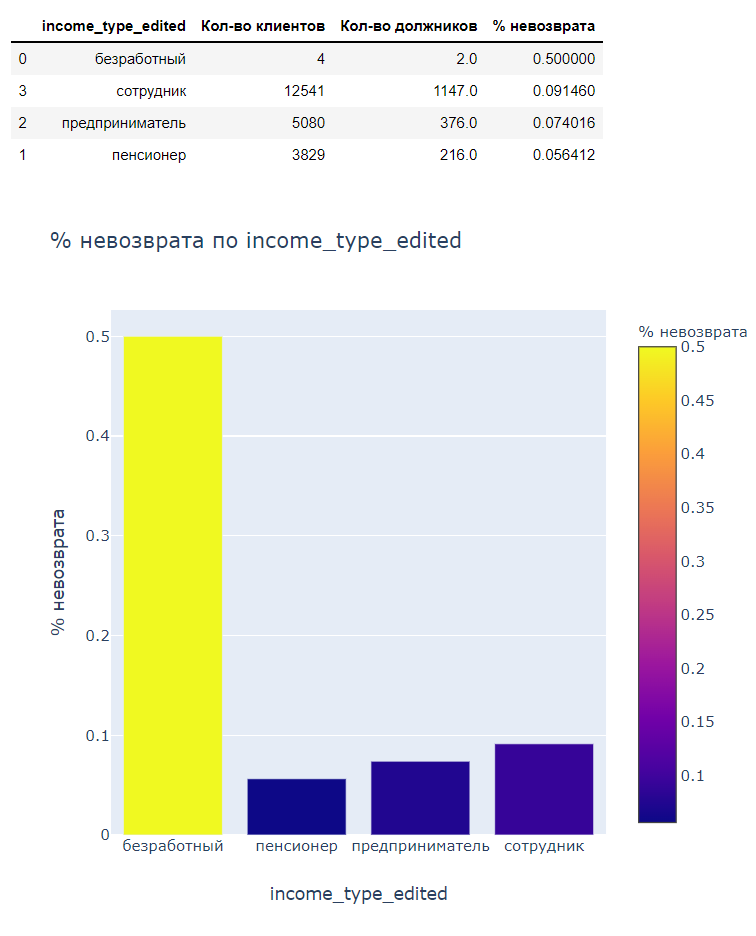

**Вывод**

Безработные имеют наибольшее количество задолженностей.

Пенсионеры имеют наименьшее количество задолженностей по кредитам, но все три категории (пенсионеры, сотрудники, предприниматели) не имеют явных различий в задолженностях.

**Как разные цели кредита влияют на его возврат в срок?**

Соотношение целей кредита и наличия задолжностей.

In [73]:
#изменим тип на целочисленный для единого стиля отображения
purpose_category_grouped_debt.astype(int)
debt_percentage_purpose = purpose_category_grouped_debt / purpose_category_grouped * 100
debt_percentage_purpose

purpose_category
автомобиль      9.359034
недвижимость    7.233373
образование     9.220035
свадьба         8.003442
dtype: float64

In [74]:
#pivot(data, 'purpose_category')
# работа функции отображена в виде изображения ниже 
# из-за особенностей отображения графиков Plotly в Github

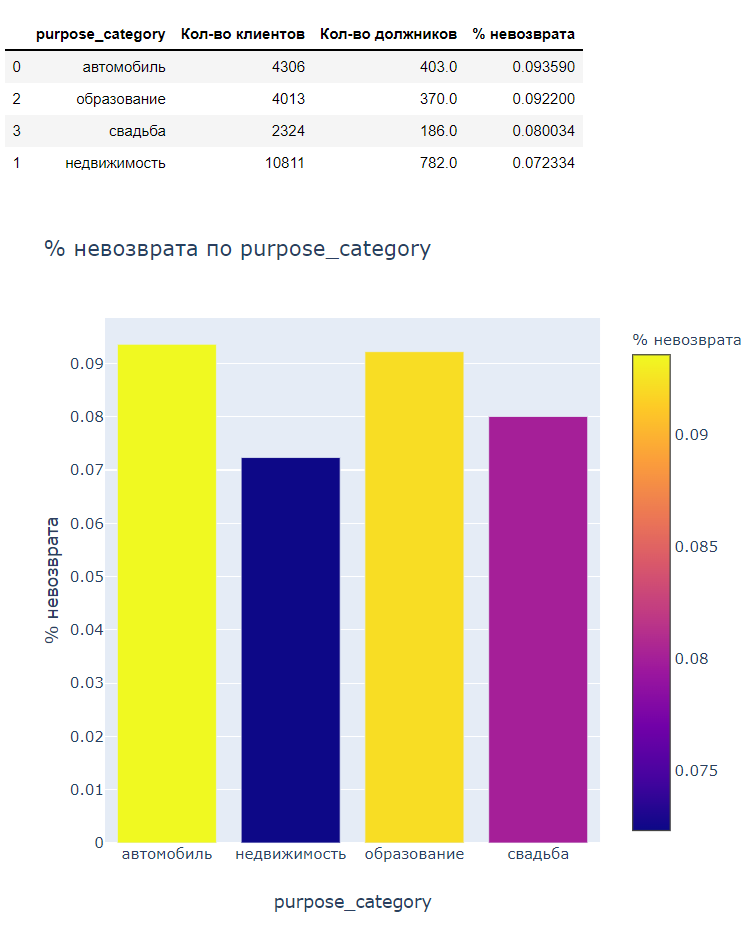

**Вывод**

Наименьшую задолженность имееют люди, которые берут кредит с целью покупки недвижимости, а наибольшую - с целью покупки автомобиля.

## Общий вывод

Результаты показали, что прослеживается прямая завимимость между семейным положением, количеством детей и возвратом кредита в срок. 

**Люди, имеющие максимальное количество задолженностей:**
- с семейным статусом "не женат/не замужем"
- имеющие один или два ребёнка
- безработные
- со средним доходом или выше среднего
- с целью взятия кредита "автомобиль"

**Люди, имеющие минимальное количество задолженностей:**

- вдовец / вдова
- женатые /замужние или в разводе
- без детей
- пенсионеры
- с высоким доходом
- с целью взятия кредита "недвижимость"